# Used Cars Sale Price Range Prediction

# Overview

This project focuses on trying to predict a price range for a used car. This is to help the client have a starting point for a price range. The data was web-scraped from Cars.com. The data scraped came from 9k used cars in Alabama. The data was very messy and a lot of steps were taken to clean it. This included extracting certain words, turning number details into actual numeric values for models. This was then taken to a couple of models. The best model was an XGBoost model. A good accuracy scored was recieved to satisfy the clients.

# Business Problem

Average car buyers can have a hard time when looking for used cars. When do they do find a used car they want, they can be unsure about the sale price. Clients want to use car details and reviews found online to get a price range

Goal is to create a model to recieve details about a car and be able to predict a range of the sale price. The model can be used as a starting point when looking at a car's sale price.

# Data Understanding

Data was gathered from Cars.com. It was web-scraped using the python library BeautifulSoup. The data scraped included a lot of details from the car. The details include, year/make/model/mileage, engine specifications, and the reviews for that model. 

A total of ~9k car's data were collected. This was all the used cars within a 200 mile radius of Birmingham, AL. 

Using Cars.com gave the basics of a car including a sale price. This is information anyone can look up when looking for a used car, so it is the best information to use in order to predict a sale price range. The reviews were also gathered, it is additional information that could be useful. The review of a car could have an effect on the price, this will be explored. 

There were some limitations and problems that the data has. There were only ~9k entries, this is okay but more would have been better. Since it was web-scraped, some information of the cars were not saved. At times the incorrect value would be in the incorrect column. The data also came out very messy so a lot of data cleaning would have to be done. The review portion of the data also has limitations. Although ~9k reviews were colleceted, only a portion (1.8k) were unique. This is because the same model cars also used the same reviews. This would limit how accurate a model can predict a sale price range due to the amount of repeated reviews. 

### Web Scraping 

- This is a summarized version of the web-scraping
- More in depth notebook can be found here [WebScrapingNotebook](WebScraping/fastScrape.ipynb)

In [1]:
# imports
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
import random
import numpy as np
from tqdm.notebook import tqdm
import re
import math

**First grabbing the individual links for each car**

In [ ]:
link_end_list = [] #list to collect all the car links

for page in tqdm(range(2,102)):
    url = f'https://www.cars.com/shopping/results/?page={page}&page_size=100&list_price_max=&makes[]=&maximum_distance=200&models[]=&stock_type=used&zip=35215'
    resp = requests.get(url).text
    soup = BeautifulSoup(resp)
    
    #getting links
    links = soup.find_all('a', attrs={"class":"vehicle-card-link js-gallery-click-link"})
    link_end = [l['href'] for l in links]
    link_end_list.append(link_end)
    time.sleep(random.choice([1, 2, 0.5]))
    

**Then going through each link and grabbing the information for each individual car**

In [63]:
reviews2 = []
driveTrain2 = []
mpg2 = []
fuelType2 = []
trans2 = []
engine2 = []
mileage2 = []
sale_price2 = []
model2 = []

error_links2 = []

In [64]:
for link in tqdm(final_links):
    #using tqdm to check progress
    
    #try to get info, if fails, move to next link
    try:
        #each car url
        url = f'https://www.cars.com{link}'
        response = requests.get(url).text
        soup = BeautifulSoup(response)
        
        #getting car model and year
        mod = soup.find_all("h1", attrs={"class":"listing-title"})
        model2.append([ti.get_text() for ti in mod])

        #getting reviews
        rev = soup.find_all("p", attrs={"class":"review-body"})
        reviews2.append([review.get_text() for review in rev])

        #getting car details
        details = soup.find_all("dl", attrs={"class":"fancy-description-list"})
        det_list = [det.get_text() for det in details]
        det_split = det_list[0].split('\n')
        #for loop to extract each part
        for i in range(len(det_split)):
            if det_split[i] == 'Drivetrain':
                driveTrain2.append(det_split[i+1])
            if det_split[i] == 'Fuel type':
                fuelType2.append(det_split[i+1])
            if det_split[i] == 'Transmission':
                trans2.append(det_split[i+1])
            if det_split[i] == 'Mileage':
                mileage2.append(det_split[i+1])
            if det_split[i] == 'MPG':
                mpg2.append(det_split[i+3])
            if det_split[i] == 'Engine':
                engine2.append(det_split[i+1])

        #getting price
        car_price = soup.find_all("span", attrs={"class":"primary-price"})
        sale_price2.append([p.get_text() for p in car_price][0])

        time.sleep(random.choice([0.1, 0.5, 0.75]))
        
    except:
        error_links2.append(link) #catching error links

**Turn into dataframe and save**

In [66]:
df2 = pd.DataFrame(list(zip(model2, reviews2, driveTrain2, mpg2, fuelType2, trans2, engine2, mileage2, sale_price2)), 
                  columns = ['Model', 'Reviews', 'DriveTrain', 'MPG', 'FuelType', 'Transmission', 'Engine', 'Mileage', 'SalePrice'])

In [67]:
df2

,Model,Reviews,DriveTrain,MPG,FuelType,Transmission,Engine,Mileage,SalePrice
0,[2020 Toyota RAV4 LE],[Virtually nothing has gone wrong with my 2020...,Front-wheel Drive,27–35,Gasoline,8-Speed Automatic,2.5L I4 16V PDI DOHC,"53,200 mi.","$29,000"
1,[],[],Front-wheel Drive,Electric,Electric,1-Speed Automatic,Electric,"62,439 mi.","$18,989"
2,[2016 Volkswagen e-Golf SE],[Stranded today. Could not get to work. Someth...,Rear-wheel Drive,18–26,Gasoline,10-Speed Automatic,3.0L V6 24V GDI DOHC Twin Turbo,"22,690 mi.","$55,975"
3,[2020 Lincoln Aviator Reserve RWD],"[Excellent road car, quiet, stable, comfortabl...",Four-wheel Drive,18–22,Gasoline,6-Speed Automatic,3.5L V6 24V PDI DOHC,"17,854 mi.","$38,900"
4,[2021 Toyota Tacoma TRD Off Road],"[PURCHASED FROM NYE TOYOTA, MY FIRST TACOMA. \...",Front-wheel Drive,28–39,Gasoline,Automatic CVT,2.5L I4 16V GDI DOHC,"60,907 mi.","$22,125"
...,...,...,...,...,...,...,...,...,...
9217,[2022 BMW X5 xDrive40i],[Only had the X5 for 4 weeks now but so far it...,Four-wheel Drive,18–25,Gasoline,8-Speed Automatic,3.6L V6 24V MPFI DOHC,"78,378 mi.","$25,500"
9218,[2019 Toyota Tacoma TRD Off Road],[When I bought my 2020 Tacoma V6 (3.5L) 4x4 in...,All-wheel Drive,18–25,Gasoline,8-Speed Automatic,3.6L V6 24V MPFI DOHC,"30,909 mi.","$35,590"
9219,[2015 INFINITI QX80 Base],[Everything is great except the rear view came...,Front-wheel Drive,23–30,Gasoline,6-SPEED A/T,4 Cylinder Engine,"30,186 mi.","$24,000"
9220,[2020 Toyota Tundra SR5],[I have owned smaller SUV's and Trucks for ove...,Four-wheel Drive,15–21,Gasoline,8-Speed Automatic,5.7L V8 16V MPFI OHV,"22,309 mi.","$71,077"


In [70]:
#df2.to_csv('carinfoV2.csv')

### Data Cleaning

- This is a summarized version of the data cleaning process
     - Full cleaning notebook can be found here [DataCleanig](CleaningWebScrape/mvp_cleaning-3bins.ipynb)
- The process will be explained with snippets of code to explain how it was done
- A before and after will be shown
- There was a lot of data cleaning invloved

In [5]:
df = pd.read_csv('data/carinfoV2.csv')

In [6]:
df = df.drop(columns='Unnamed: 0')

**Data is dirty, time to clean**

In [7]:
df

,Model,Reviews,DriveTrain,MPG,FuelType,Transmission,Engine,Mileage,SalePrice
0,['2020 Toyota RAV4 LE'],['Virtually nothing has gone wrong with my 202...,Front-wheel Drive,27–35,Gasoline,8-Speed Automatic,2.5L I4 16V PDI DOHC,"53,200 mi.","$29,000"
1,[],[],Front-wheel Drive,Electric,Electric,1-Speed Automatic,Electric,"62,439 mi.","$18,989"
2,['2016 Volkswagen e-Golf SE'],"[""Stranded today. Could not get to work. Somet...",Rear-wheel Drive,18–26,Gasoline,10-Speed Automatic,3.0L V6 24V GDI DOHC Twin Turbo,"22,690 mi.","$55,975"
3,['2020 Lincoln Aviator Reserve RWD'],"['Excellent road car, quiet, stable, comfortab...",Four-wheel Drive,18–22,Gasoline,6-Speed Automatic,3.5L V6 24V PDI DOHC,"17,854 mi.","$38,900"
4,['2021 Toyota Tacoma TRD Off Road'],"['PURCHASED FROM NYE TOYOTA, MY FIRST TACOMA. ...",Front-wheel Drive,28–39,Gasoline,Automatic CVT,2.5L I4 16V GDI DOHC,"60,907 mi.","$22,125"
...,...,...,...,...,...,...,...,...,...
9217,['2022 BMW X5 xDrive40i'],['Only had the X5 for 4 weeks now but so far i...,Four-wheel Drive,18–25,Gasoline,8-Speed Automatic,3.6L V6 24V MPFI DOHC,"78,378 mi.","$25,500"
9218,['2019 Toyota Tacoma TRD Off Road'],['When I bought my 2020 Tacoma V6 (3.5L) 4x4 i...,All-wheel Drive,18–25,Gasoline,8-Speed Automatic,3.6L V6 24V MPFI DOHC,"30,909 mi.","$35,590"
9219,['2015 INFINITI QX80 Base'],['Everything is great except the rear view cam...,Front-wheel Drive,23–30,Gasoline,6-SPEED A/T,4 Cylinder Engine,"30,186 mi.","$24,000"
9220,['2020 Toyota Tundra SR5'],['I have owned smaller SUV\'s and Trucks for o...,Four-wheel Drive,15–21,Gasoline,8-Speed Automatic,5.7L V8 16V MPFI OHV,"22,309 mi.","$71,077"


Although each row/column had some sort of 'value', some of those values gave no information (such as row 0 has '[]' as a value). A couple hundred of these rows had special characters that could be viewed as empty values. The first step would be to look at the rows with special characters and see what to do.

A lot of the special rows had multiple empty columns, so it was decided to remove those rows. After removing those, the data frame was reduced to ~8.4k rows

In [17]:
data #note, this cell will not run, it is being used to show the 'after', this should be visible on the github

,Model,Reviews,DriveTrain,MPG,FuelType,Transmission,Engine,Mileage,SalePrice
0,['2020 Toyota RAV4 LE'],['Virtually nothing has gone wrong with my 202...,Front-wheel Drive,27–35,Gasoline,8-Speed Automatic,2.5L I4 16V PDI DOHC,"53,200 mi.","$29,000"
1,['2016 Volkswagen e-Golf SE'],"[""Stranded today. Could not get to work. Somet...",Rear-wheel Drive,18–26,Gasoline,10-Speed Automatic,3.0L V6 24V GDI DOHC Twin Turbo,"22,690 mi.","$55,975"
2,['2020 Lincoln Aviator Reserve RWD'],"['Excellent road car, quiet, stable, comfortab...",Four-wheel Drive,18–22,Gasoline,6-Speed Automatic,3.5L V6 24V PDI DOHC,"17,854 mi.","$38,900"
3,['2021 Toyota Tacoma TRD Off Road'],"['PURCHASED FROM NYE TOYOTA, MY FIRST TACOMA. ...",Front-wheel Drive,28–39,Gasoline,Automatic CVT,2.5L I4 16V GDI DOHC,"60,907 mi.","$22,125"
4,['2020 Nissan Altima 2.5 S'],['I’ve own a 2020 Altima (under 30k miles) for...,Front-wheel Drive,24–32,Gasoline,6-Speed Automatic,2.4L I4 16V GDI DOHC,"41,614 mi.","$23,946"
...,...,...,...,...,...,...,...,...,...
8476,['2022 BMW X5 xDrive40i'],['Only had the X5 for 4 weeks now but so far i...,Four-wheel Drive,18–25,Gasoline,8-Speed Automatic,3.6L V6 24V MPFI DOHC,"78,378 mi.","$25,500"
8477,['2019 Toyota Tacoma TRD Off Road'],['When I bought my 2020 Tacoma V6 (3.5L) 4x4 i...,All-wheel Drive,18–25,Gasoline,8-Speed Automatic,3.6L V6 24V MPFI DOHC,"30,909 mi.","$35,590"
8478,['2015 INFINITI QX80 Base'],['Everything is great except the rear view cam...,Front-wheel Drive,23–30,Gasoline,6-SPEED A/T,4 Cylinder Engine,"30,186 mi.","$24,000"
8479,['2020 Toyota Tundra SR5'],['I have owned smaller SUV\'s and Trucks for o...,Four-wheel Drive,15–21,Gasoline,8-Speed Automatic,5.7L V8 16V MPFI OHV,"22,309 mi.","$71,077"


The next step in cleaning would be to turn SalePrice into an actual integer pandas can read. Once the SalePrice was a numeric value, we can use pandas function to bin our SalePrice into three categories. The original plan was to have five categories but it was decided to keep three. This is so the models could have better predictions. According to the business understanding, clients would use this model as a starting point for used car prices, so having three price ranges is not a bad start.

Then the reviews would have to be cleaned up. This was done by creating a function to pass each review through, this function would also help clean up the Model column.

In [8]:
def review_cleaner(rev):
    '''
    Takes in a string and removes special characters.
    Returns the string with no special characters.
    '''
    clean = re.sub(r'\\n', '', rev)
    clean = re.sub(r'\\r', '', clean)
    clean = clean.replace('[', '')
    clean = clean.replace(']', '')
    clean = clean.replace('"', '')
    clean = clean.replace("'", "")
    return clean

With the Model column being clean, we can extract the year/make/model for each car and place them in their respective columns. DriveTrain was reduced down to their acronyms (FWD,AWD,RWD).

The next step in cleaning would be to turn the current numeric values into true floats/integers. This would include columns such as Mileage, MPG, and Year.

At this point, the columns 'FuelType' and 'Transmission' were dropped. Both column were dominated by a single value. Both Gasoline and Automatic made up 95% of the values in their respective columns. This would not help the models at all since those columns essentially have a single value to predict. 

This brought us down to clean the last column, 'Engine'. With the 'Engine' column we can extract the size of the motor (ex. 3.5L) and the number of cyliders (ex. v6). Two seperate columns were created to for the engine size and number of cylinders. A big issue arrived, the data was not consistant accross the columns (incorrect values, different notation). To help with this, two indicator columns were made to check if they were in the correct format or not. By indexing through the indicator columns, we could then fill in the correct values for each column. 

In [86]:
data['hasCyl'] = data['Cylinders'].str.isdigit() #if it has some sort of integer then it is true
                                                  #it does have a correct cylinder number, else its false

In [87]:
data['hasSize'] = data['EngineSize'].str.contains('L') #if the string contains 'L' then it has the correct value (3.5L)
                                                       # if it doesn't it is false

In [91]:
data[(data['hasCyl'].isna() == False) & (data['hasSize'] == False)]

,DriveTrain,MPG,Mileage,SalePrice,PriceCategory,CleanReviews,Year,Make,Car_Model,EngineSize,Cylinders,hasCyl,hasSize
15,FWD,29.0,105026.0,14433.0,Cheap,"Beautiful, comfortable, responsive... my only ...",2020.0,Lexus,ES,Regular,Unleaded,False,False
21,FWD,20.0,28716.0,47590.0,Expensive,The X3 m40i is the best family vehicle. Got a ...,2019.0,BMW,X3,V6,Cylinder,False,False
36,RWD,25.0,98467.0,24786.0,Cheap,I got my crew cab 2019 F250 XLT with the 6.2L ...,2019.0,Ford,F-250,Intercooled,Turbo,False,False
46,AWD,27.0,32708.0,31998.0,Average,"61000 miles 2016 Sierra 1500. 2,800 repair for...",2021.0,GMC,Sierra,4,Cylinder,False,False
58,FWD,18.0,19855.0,104995.0,Expensive,No surprise .... good performance. It is a M...,2014.0,Mercedes-Benz,CLA-Class,V6,none,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8395,AWD,24.0,20307.0,40991.0,Average,"Truck rides like a car. Plenty of power, goo...",2013.0,Ford,F-150,4,Cyl,False,False
8409,FWD,19.0,26672.0,57000.0,Expensive,I purchased my black on black 2017 Accord EX-L...,2017.0,Honda,Accord,Regular,Unleaded,False,False
8437,FWD,18.0,10896.0,123999.0,Expensive,have owned 356s for 55 yrs. this is my first n...,2018.0,Porsche,Panamera,V6,none,False,False
8446,FWD,19.0,59432.0,44792.0,Average,63000 miles and transmission went out. Spoke t...,2019.0,Dodge,Grand,6,Cyl,False,False


In [92]:
newSize = [] #list to place all our values

In [93]:
for i in range(0,len(data)): #looping through the index
    
    if data['hasCyl'][i] == False and data['hasSize'][i]==False: #check when indicator cols are false
        if 'L' in data['Cylinders'][i]: #if it has L use it, correct value
            newSize.append(data['Cylinders'][i])
        elif '6' in data['EngineSize'][i]: #if it has 6 use 3.5L, most common for 6 cylinders
            newSize.append('3.5L')
        elif '4' in data['EngineSize'][i]: #if it has 4 use 2.5L, most common for 4 cylinders
            newSize.append('2.5L')
        else:
            newSize.append('unknown') #we just don't know

    elif data['hasSize'][i] == True or math.isnan(data['hasCyl'][i]) == True:
        newSize.append(data['EngineSize'][i]) #if it already has a valid value, use it
    else:
        newSize.append(data['EngineSize'][i]) #if it already has a valid value, use it
    

In [94]:
lst = []
for x in newSize:
    if 'L' not in x or 'Engine' in x: # if it doesnt have L or has Engine, we dont know
        x = 'unknown'
        lst.append(x)
    else: #it does have an L so we use it
        x = x
        lst.append(x)

In [97]:
newCyl = [] 

In [99]:
for i in range(0,len(data)): #looping through index
    
    if data['hasCyl'][i] == False: #checking our indicator column
        if '2' in data['newSize'][i]: #if it has a 2 (2.5L, 2.8L, etc.) then its most likely a 4 cylinder
            newCyl.append(4)
        elif '3' in data['newSize'][i]: #if it has a 3 then its most likely a 6 cylinder
            newCyl.append(6)
        elif '4' in data['newSize'][i]: #if it has a 4 then its most likely a 8 cylinder
            newCyl.append(8)
        else:
            newCyl.append('unknown') #we just dont know
    else:
        newCyl.append(data['Cylinders'][i]) #has correct value 

Once we had correct values in each of the columns, the final step was to only include the top 25 makes for each car. If car make was not in the top 25 makes, it would be labled as other. This was done for modeling purposes so a model can more easily predict an outcome. The make of the car was dropped from the dataset. A lot of times, people would want to know the make of a car vs the model. The make of a car has more of a sigificance in the car community. The the care is made by a reliable company. such as Toyota, they would usually not question the model of a car.

The data has been cleaned/prepared for preprocessing and modeling 

In [13]:
final_data = pd.read_csv('data/CleanData3bins.csv')

In [14]:
final_data = final_data.drop(columns='Unnamed: 0')

In [15]:
final_data

,DriveTrain,Mileage,SalePrice,PriceCategory,CleanReviews,Year,newSize,newCyl,newMake,mpg
0,FWD,53200.0,29000.0,Average,Virtually nothing has gone wrong with my 2020 ...,2020.0,2.5,4,Toyota,27.0
1,RWD,22690.0,55975.0,Expensive,Stranded today. Could not get to work. Somethi...,2016.0,3.0,6,Volkswagen,18.0
2,FWD,17854.0,38900.0,Average,"Excellent road car, quiet, stable, comfortable...",2020.0,3.5,6,Other,18.0
3,FWD,60907.0,22125.0,Cheap,"PURCHASED FROM NYE TOYOTA, MY FIRST TACOMA. LO...",2021.0,2.5,4,Toyota,28.0
4,FWD,41614.0,23946.0,Cheap,I’ve own a 2020 Altima (under 30k miles) for a...,2020.0,2.4,4,Nissan,24.0
...,...,...,...,...,...,...,...,...,...,...
8469,FWD,78378.0,25500.0,Cheap,Only had the X5 for 4 weeks now but so far it ...,2022.0,3.6,6,BMW,18.0
8470,AWD,30909.0,35590.0,Average,When I bought my 2020 Tacoma V6 (3.5L) 4x4 in ...,2019.0,3.6,6,Toyota,18.0
8471,FWD,30186.0,24000.0,Cheap,Everything is great except the rear view camer...,2015.0,2.5,4,INFINITI,23.0
8472,FWD,22309.0,71077.0,Expensive,I have owned smaller SUV\s and Trucks for over...,2020.0,5.7,8,Toyota,15.0


# Modeling

There were two types of models being done. One model would be predicting the sale price range of a car using car details, and the other model would be using the car reviews. The car review models will use some NLP methods to create predictions.
Things like stemming, lemmatizing, tokenization, vectorization were attempted. The code for this section should be able to run with no problems.

In [17]:
from collections import defaultdict
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords, wordnet

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import re
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import train_test_split, cross_validate
import xgboost as xgb

### NLP Model For Reviews

A lot of work was done in exploring NLP (Natural Language Processing). The full exploration process can be seen here [NLPExploration](NLP-Modeling/modelNLP.ipynb)

**Stemming/Lemmantizing**
Attempted to stem and lemmantize the reviews.

**Vectorizing**
Tried TFIDF Vectorizer and Count Vectorizer.

**Sentiment Analysis**
Used the TextBlob library to add a type of sentiment analysis. Tried positive/negative tag for each review. TextBlob also gives a polarity and subjectivity metrics, attempted to use that also. 

- Stemming and lemmatizing text did not help much
- Reason is probably because there is not enough variety in the reviews to make a difference
- Using a 'vanilla' tfidf vectorizer gave the best model

In [19]:
data = pd.read_csv('data/CleanData3bins.csv')

In [20]:
data = data.drop(columns='Unnamed: 0')

In [21]:
df = data[['CleanReviews', 'PriceCategory']]

In [22]:
df.head()

,CleanReviews,PriceCategory
0,Virtually nothing has gone wrong with my 2020 ...,Average
1,Stranded today. Could not get to work. Somethi...,Expensive
2,"Excellent road car, quiet, stable, comfortable...",Average
3,"PURCHASED FROM NYE TOYOTA, MY FIRST TACOMA. LO...",Cheap
4,I’ve own a 2020 Altima (under 30k miles) for a...,Cheap


### Pre-proccessing For NLP

- Need to lowercase the reviews

In [23]:
df['CleanReviews'] = df['CleanReviews'].str.lower()

<ipython-input-23-f0607efd20df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CleanReviews'] = df['CleanReviews'].str.lower()


In [24]:
df.head()

,CleanReviews,PriceCategory
0,virtually nothing has gone wrong with my 2020 ...,Average
1,stranded today. could not get to work. somethi...,Expensive
2,"excellent road car, quiet, stable, comfortable...",Average
3,"purchased from nye toyota, my first tacoma. lo...",Cheap
4,i’ve own a 2020 altima (under 30k miles) for a...,Cheap


## Train, Test,  Split

- Creating a holdout set to use at the very end

In [25]:
X = data['CleanReviews']
y = data['PriceCategory']

In [26]:
X_t, X_hold, y_t, y_hold = train_test_split(X, y, test_size=0.10, random_state=42)

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.25, random_state=42)

## Vectorize

In [28]:
#stopwords
sw = stopwords.words('english')

In [29]:
vectorizer = TfidfVectorizer(
    token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)",
    stop_words=sw,
#     max_df=.95,  # removes words that appear in more than 95% of docs !!not using either, produces better model without!!
#     min_df=2     # removes words that appear 2 or fewer times
)

In [30]:
vectorizer.fit(X_train)

X_train_vec = vectorizer.transform(X_train)
X_val_vec = vectorizer.transform(X_val)

In [31]:
classifier = MultinomialNB()
classifier.fit(X_train_vec, y_train)
classifier.score(X_val_vec, y_val)

0.41321447299423175

- not bad score
- only fraction of total reviews are unique reviews
- 41% accuracy seems good considering I am trying to model human language :)

## Car Details Model

- testing out different vanilla models
- getting the best one and try to use it with nlp model


The data has 3 target variables, so it is not a binary classification problem. A quick google search gave me the best models for multiclass problems using the sklearn library https://scikit-learn.org/stable/modules/multiclass.html 

From this list a total of 6 models were chosen. Will only show the models with the better test scores
 - KNN
 - Decision Tree
 - Logistic Regression
 - Random Forest
 - Ridge Classifier
 - XGBoost

In [32]:
data.head()

,DriveTrain,Mileage,SalePrice,PriceCategory,CleanReviews,Year,newSize,newCyl,newMake,mpg
0,FWD,53200.0,29000.0,Average,Virtually nothing has gone wrong with my 2020 ...,2020.0,2.5,4,Toyota,27.0
1,RWD,22690.0,55975.0,Expensive,Stranded today. Could not get to work. Somethi...,2016.0,3.0,6,Volkswagen,18.0
2,FWD,17854.0,38900.0,Average,"Excellent road car, quiet, stable, comfortable...",2020.0,3.5,6,Other,18.0
3,FWD,60907.0,22125.0,Cheap,"PURCHASED FROM NYE TOYOTA, MY FIRST TACOMA. LO...",2021.0,2.5,4,Toyota,28.0
4,FWD,41614.0,23946.0,Cheap,I’ve own a 2020 Altima (under 30k miles) for a...,2020.0,2.4,4,Nissan,24.0


In [33]:
data['DriveTrain'].value_counts()

FWD    5281
AWD    1801
RWD    1392
Name: DriveTrain, dtype: int64

In [34]:
X = data.drop(columns=['CleanReviews', 'PriceCategory', 'SalePrice'])
y = data['PriceCategory']

**Creating a train test split and a holdout set to use at the end**

In [35]:
X_t, X_hold, y_t, y_hold = train_test_split(X, y, test_size=0.10, random_state=42)

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.25, random_state=42)

**Creating a column transformer to use on models**

In [37]:
num_cols = ['Mileage', 'Year', 'newSize', 'newCyl', 'mpg']
cat_cols = ['DriveTrain', 'newMake']

In [38]:
cat_transformer = OneHotEncoder(drop=['RWD', 'Other'])

In [39]:
num_transformer = MinMaxScaler()

In [40]:
preprocessor = ColumnTransformer(transformers=[
    ("num_trans", num_transformer, num_cols),
    ('cat_trans', cat_transformer, cat_cols)
])

In [41]:
preprocessor.fit_transform(X_train)

<5719x32 sparse matrix of type '<class 'numpy.float64'>'
	with 38788 stored elements in Compressed Sparse Row format>

# Knn

In [42]:
clf_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

In [43]:
clf_knn.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_trans', MinMaxScaler(),
                                                  ['Mileage', 'Year', 'newSize',
                                                   'newCyl', 'mpg']),
                                                 ('cat_trans',
                                                  OneHotEncoder(drop=['RWD',
                                                                      'Other']),
                                                  ['DriveTrain', 'newMake'])])),
                ('knn', KNeighborsClassifier())])

In [44]:
print(f"Train Accuracy: {clf_knn.score(X_train, y_train)}")
print(f"Test Accuracy: {clf_knn.score(X_val, y_val)}")

Train Accuracy: 0.7600979192166463
Test Accuracy: 0.6324069218668065


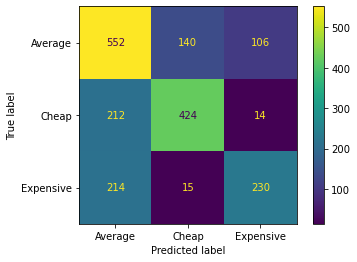

In [45]:
plot_confusion_matrix(clf_knn, X_val, y_val);

# Decision Tree

In [46]:
clf_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('dt', DecisionTreeClassifier(random_state=42))
])

In [47]:
clf_dt.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_trans', MinMaxScaler(),
                                                  ['Mileage', 'Year', 'newSize',
                                                   'newCyl', 'mpg']),
                                                 ('cat_trans',
                                                  OneHotEncoder(drop=['RWD',
                                                                      'Other']),
                                                  ['DriveTrain', 'newMake'])])),
                ('dt', DecisionTreeClassifier(random_state=42))])

In [48]:
print(f"Train Accuracy: {clf_dt.score(X_train, y_train)}")
print(f"Test Accuracy: {clf_dt.score(X_val, y_val)}")

Train Accuracy: 1.0
Test Accuracy: 0.6769795490298899


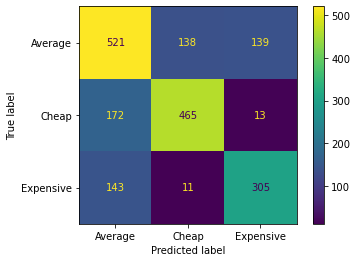

In [49]:
plot_confusion_matrix(clf_dt, X_val, y_val);

# Random Forest

In [50]:
clf_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(max_depth=10, random_state=42))
])

In [51]:
clf_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_trans', MinMaxScaler(),
                                                  ['Mileage', 'Year', 'newSize',
                                                   'newCyl', 'mpg']),
                                                 ('cat_trans',
                                                  OneHotEncoder(drop=['RWD',
                                                                      'Other']),
                                                  ['DriveTrain', 'newMake'])])),
                ('rf', RandomForestClassifier(max_depth=10, random_state=42))])

In [52]:
print(f"Train Accuracy: {clf_rf.score(X_train, y_train)}")
print(f"Test Accuracy: {clf_rf.score(X_val, y_val)}")

Train Accuracy: 0.802063297779332
Test Accuracy: 0.724698479286838


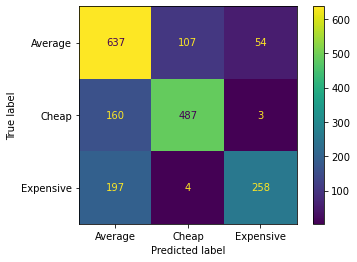

In [53]:
plot_confusion_matrix(clf_rf, X_val, y_val);

# XGBoost
- Best model so far

In [54]:
clf_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb', xgb.XGBClassifier(random_state=42, 
                              learning_rate=.1, 
                              max_depth=6,
                             n_estimators=50))
])

In [55]:
clf_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_trans', MinMaxScaler(),
                                                  ['Mileage', 'Year', 'newSize',
                                                   'newCyl', 'mpg']),
                                                 ('cat_trans',
                                                  OneHotEncoder(drop=['RWD',
                                                                      'Other']),
                                                  ['DriveTrain', 'newMake'])])),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               import...type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=6,
          

In [56]:
print(f"Train Accuracy: {clf_xgb.score(X_train, y_train)}")
print(f"Test Accuracy: {clf_xgb.score(X_val, y_val)}")

Train Accuracy: 0.806609547123623
Test Accuracy: 0.7556371263765076


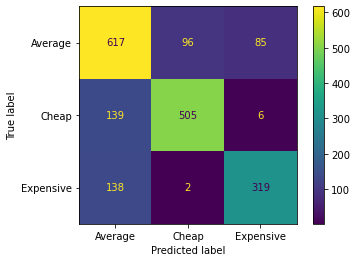

In [57]:
plot_confusion_matrix(clf_xgb, X_val, y_val);

In [58]:
y_val.value_counts()

Average      798
Cheap        650
Expensive    459
Name: PriceCategory, dtype: int64

**Has a hard time with average prices, thinking they are cheap or expensive**

# Results

The best prediction scores cam from an XGBoost model. The model had accuracy score of 75%. The NaiveBayes model will not be used to predict prices based on car reviews.

In [59]:
print(f"Test Accuracy: {clf_xgb.score(X_val, y_val)}")

Test Accuracy: 0.7556371263765076


# Conclusions


- Model is able to give a good starting price point for clients 
    - Clients can be confident the model's prediction can give them a good price range for a used car

- Difficult to incorporate reviews as a metric into predicting car price
    - There were not enough unique reviews to make a good predictions
    - Even when trying different NLP approaches, model did not get any better.
    - It did good for the data it had, but not worth putting into a model


# Future Analysis

- Collect more unique reviews
    - Having more unique reviews will be more useful for the model
- Find a way to better incorporate both models
    - By incorporating two models, one for reviews and one for car details, could produce a more accurate prediction
- Create a better web-scraper/ Collecting more data
    - Having more data is good, in this case more data means different cars from different states/larger radius.
